# ECEN 520 Final Project - VAR implementation
## Download the data to begin processing steps

In [ ]:
import pandas as pd
import polars as pl

df = pd.read_parquet("/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=0/part-0.parquet")
df_pl = pl.read_parquet("/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=0/part-0.parquet")

## There are a lot of partially or fully empty columns in each parquet so we need to identify these as the first steps of preprocessing

In [ ]:
# Three Cases
# 1. Fully Empty columns : we can just drop them
# 2. Partially Empty Columns: we can impute them
# 3. Full Columns : No imputation necessary

empty_columns = []
fully_filled_columns = []
partially_empty_columns = []

for feature in df_pl.columns:
    # Count empty and non-empty rows
    empty_rows = df_pl[feature].is_null().sum()
    nonempty_rows = len(df_pl[feature]) - empty_rows

    # Classify the columns based on the counts
    if nonempty_rows == 0:
        empty_columns.append(feature)
    elif empty_rows == 0:
        fully_filled_columns.append(feature)
    else:
        partially_empty_columns.append(feature)

# We don't use df_pl again, so delete it to conserve memory
del df_pl

## Next we drop the empty columns, sort the values by time, fill columns which are partially empty, and organize the columns into different groupings

In this section we also merge the time series together to create a relative timestamp for each entry to maintain one index. This combines the date_id with the time_id to make the time series more interpretable for a VAR model (and also to reduce the dimensionality of the set).

In [ ]:
# drop empty columns using imputer
df = df.drop(empty_columns, axis = 1)

# Fill in partially empty columns
for feature in partially_empty_columns:
    df[feature] = df.groupby('symbol_id')[feature].transform(lambda x: x.ffill().bfill())

# Split data temporally - in partition0 there are 170 days and 849 unique time ids per day
df = df.sort_values(['date_id', 'time_id'])
date_counts = df.date_id.value_counts()
date_counts = pd.DataFrame(date_counts.sort_index())
date_counts['cumulative_sum'] = date_counts['count'].cumsum()

# Combine date_id and time_id into the same column for training the VAR model
max_time_id = 849  # Number of unique time stamps per day
df['relative_timestamp'] = df['date_id'] * max_time_id + df['time_id']

# Organize columns into different groups
TIME_FEATURES = ['relative_timestamp']
MARKET_FEATURES = [f'feature_{i:02}' for i in range(0,79) if f'feature_{i:02}' in df.columns]
RESPONDER_FEATURES = [f'responder_{i}' for i in range(0,9) if f'responder_{i}' in df.columns]
SYMBOL_FEATURES = ['symbol_id']

## Normalize all the responders and feature using standard scaler. 

This is a little dicey because we don't know whether or not the features are already normalized, but this is a risk we are willing to take.

In [ ]:
# Normalize Data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cols_to_normalize = MARKET_FEATURES + RESPONDER_FEATURES
df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])

## Split the data into train, validation, and testing sets.
We are using the time index instead of train-test-split. We need to do this because train-test-split will choose random values which will cause our model to improperly train and overfit. This is because it is time-series data, so if we pick testing points in between the training points, these values will be much easier to predict since the model has seen the surrounding values. Our train, val, and test percentages are 60%, 20%, and 20% respectively.

In [ ]:
# Determine splitting points
total = len(df)
train_percentage = 0.95
val_percentage = 0.05
test_percentage = 0.0
apprx_train_len = int(total*train_percentage)
apprx_val_len = int(total*val_percentage) 
apprx_test_len = total - apprx_train_len - apprx_val_len

# Determine Splitting points
def split_func(row):
    s = row['cumulative_sum']
    if s <= apprx_train_len:
        return 'Train'
    elif (s > apprx_train_len) and (s <= apprx_train_len + apprx_val_len):
        return 'Val'
    elif (s > apprx_train_len + apprx_val_len):
        return 'Test'
    else:
        raise ValueError

date_counts['Split'] = date_counts.apply(split_func, axis = 1)
last_train_data = date_counts[date_counts.Split == 'Train'].tail(1) 
first_test_data = date_counts[date_counts.Split == 'Test'].head(1)

# Once Splitting points are determined, then make the necessary splits
def split_func_df(row):
    s = row['date_id']
    if s <= last_train_data.index[0]:
        return 'Train'
    elif (s > last_train_data.index[0]) and (s < first_test_data.index[0]):
        return 'Val'
    elif (s >= first_test_data.index[0]):
        return 'Test'
    else:
        raise ValueError

# Drop time and date id since we combined them into an index above

df['Split'] = df.apply(split_func_df, axis = 1)
df['Split'].value_counts()

df = df.drop('time_id', axis='columns')
df = df.drop('date_id', axis='columns')

train_df = df[df.Split == 'Train']
val_df = df[df.Split == 'Val']
test_df = df[df.Split == 'Test']

## Now that preprocessing is done, we can start implementing the VAR model. 

The VAR model aims to find relationships between all elements, and not just the relation between features and the target value (responder_6). This makes it very memory intensive to train. In fact it will use even more memory with the more lags that are selected. Lags the number of previous observations of each variable that are used to predict the current values of the variables.

In [ ]:
del df

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

train = train_df[['relative_timestamp','symbol_id','feature_06', 'feature_07', 'feature_05', 'feature_68', 'responder_6']]
val = val_df[['relative_timestamp','symbol_id','feature_06', 'feature_07', 'feature_05', 'feature_68', 'responder_6']]
model = VAR(train)

## Correlation matrix to determine the top-4 features
Following code is used for determining correlation between features and responder_6. Normal operation of this code doesn't require this section to be run.

In [ ]:
# correlation_results = []
# train_x_no_responder = train_df[MARKET_FEATURES]
# for feature in train_x_no_responder.columns:
#     correlation = train_x_no_responder[feature].corr(train_y['responder_6'])
#     correlation_spear = train_x_no_responder[feature].corr(train_y['responder_6'], method='spearman')
#     correlation_results.append((feature, abs(correlation), abs(correlation_spear)))

# # Create a DataFrame from the results
# correlation_df = pd.DataFrame(correlation_results, columns=['Feature', 'Pearson Correlation', 'Spearman Correlation'])

# # Sort by the absolute value of Pearson correlation (you can choose Spearman if needed)
# correlation_df = correlation_df.sort_values(by='Pearson Correlation', ascending=False)

# # Print the sorted results
# print(correlation_df)

## Now that data preprocessing is done, we can start testing the VAR model
For training, we are using the top-4 features. We use the top-4 features because this makes it possible to train the model given the limited Kaggle resources. These features were chosen using a correlation matrix which is detailed in the VAR notebook. A future implementation could use PCA instead of just choosing these K-features. Note, that unlike a VAR model,the time-series data is left as distinct dates and times instead of combining them into one index.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

train = train_df[['relative_timestamp','symbol_id','feature_06', 'feature_07', 'feature_05', 'feature_68', 'responder_6']]
val = val_df[['relative_timestamp','symbol_id','feature_06', 'feature_07', 'feature_05', 'feature_68', 'responder_6']]
model = VAR(train)

## Memory Issues

This code is supposed to determine the ideal number of lags given a trained model, but it would always select the max number that the system could support (around 124). I have deduced that this is not actually the ideal max but the best result it can achieve given the memory constraints.

In [ ]:
lags = model.select_order()
print(lags.summary())

## Ok, there are memory issues, but is there still any promise of usable results?

The following code tests the VAR model with 124 lags (I think the ideal number is around 250 given the recommended max is 1/4 of the time you are trying to predict, which is 849 time steps). To manage memory even further we even implemented batch forcasting to limit the number of entries being processed at any given time.

In [2]:
lags = 124
results = model.fit(lags)  # Determine the optimal lag using `model.select_order()`
forecast_steps = len(val)  # Number of steps to forecast
# forecast = results.forecast(train.values[-lags:], steps=forecast_steps)

batch_size = 100  # Adjust batch size as needed
forecasts = []
for i in range(0, forecast_steps, batch_size):
    end_idx = min(i + batch_size, forecast_steps)
    batch_forecast = results.forecast(train.values[-lags:], steps=end_idx - i)
    forecasts.append(batch_forecast)

forecast = np.vstack(forecasts)  # Combine batches into a single array


forecast_df = pd.DataFrame(forecast, columns=val.columns)
forecast_df.index = val.index  # Align index

ground_truth = val[['relative_timestamp','symbol_id','feature_06', 'feature_07', 'feature_05', 'feature_68', 'responder_6']]

## Testing the model
To test the model, we primarily plotted the forecasted value vs the actual value for all the features that were a part of the training set.

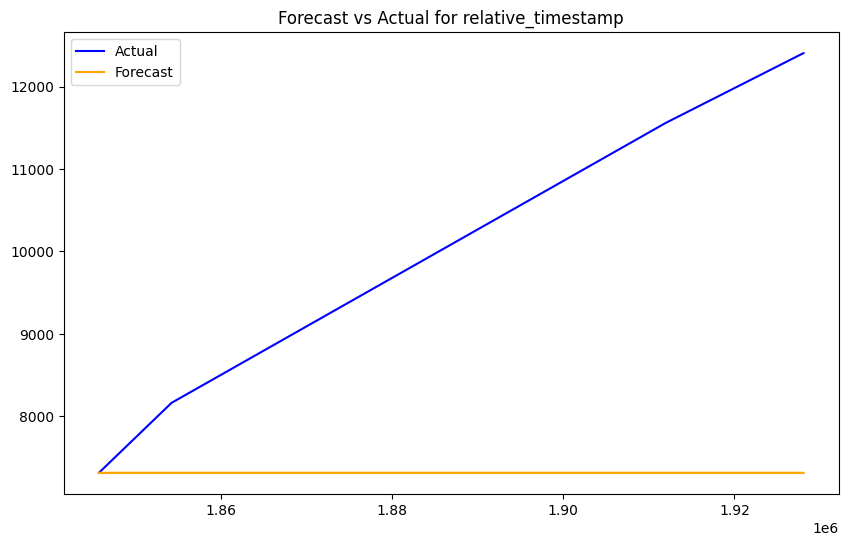

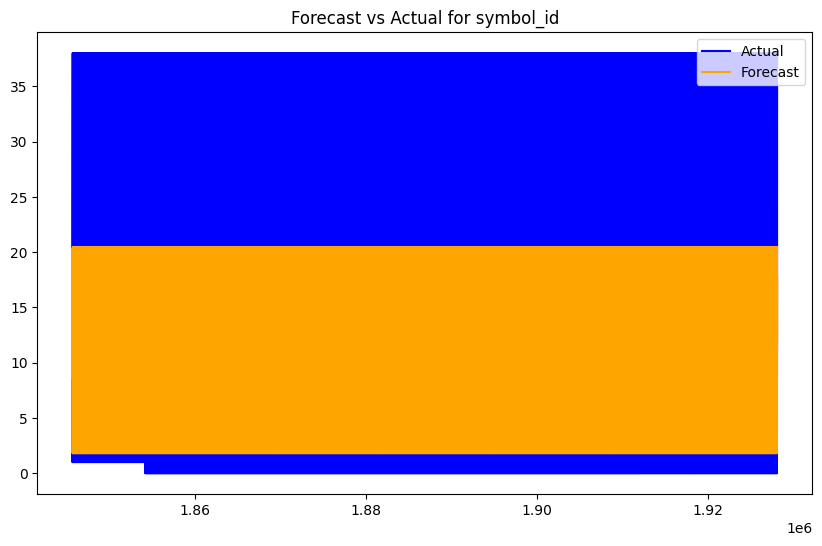

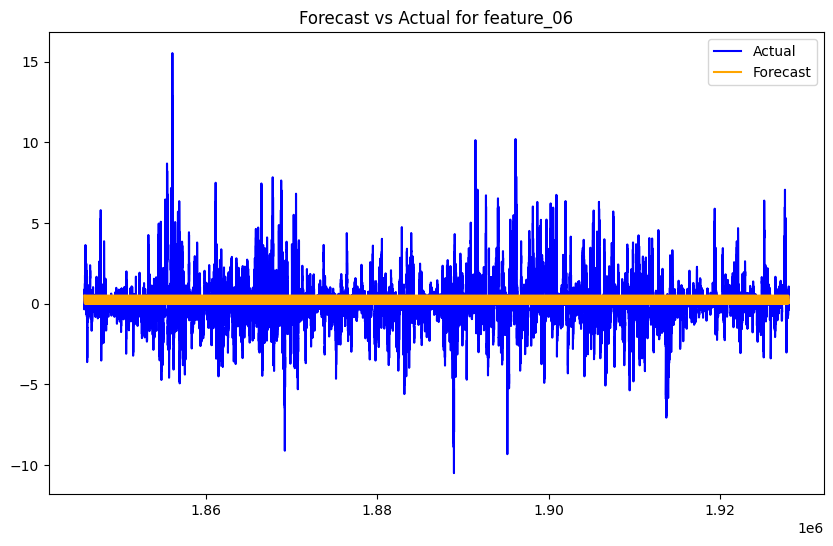

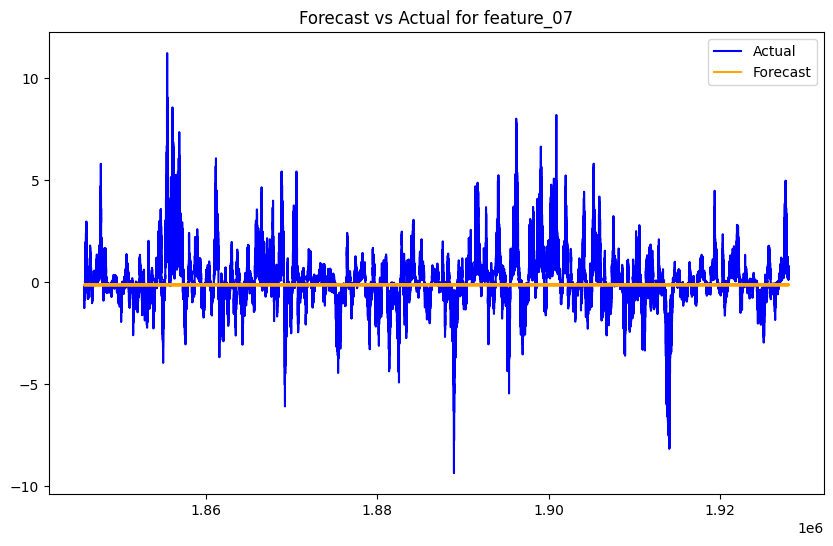

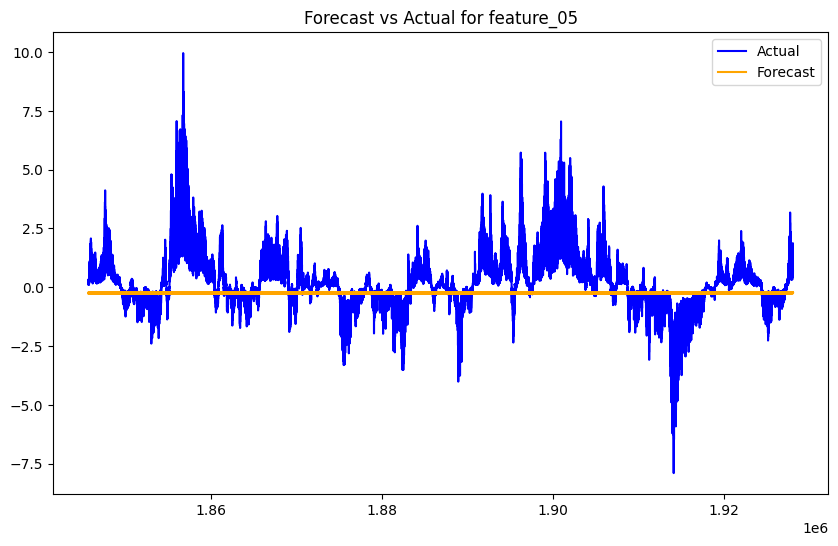

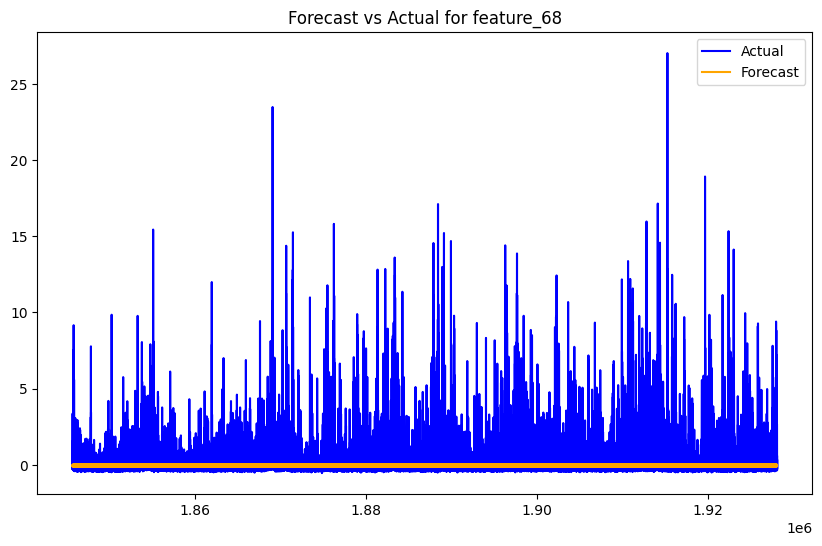

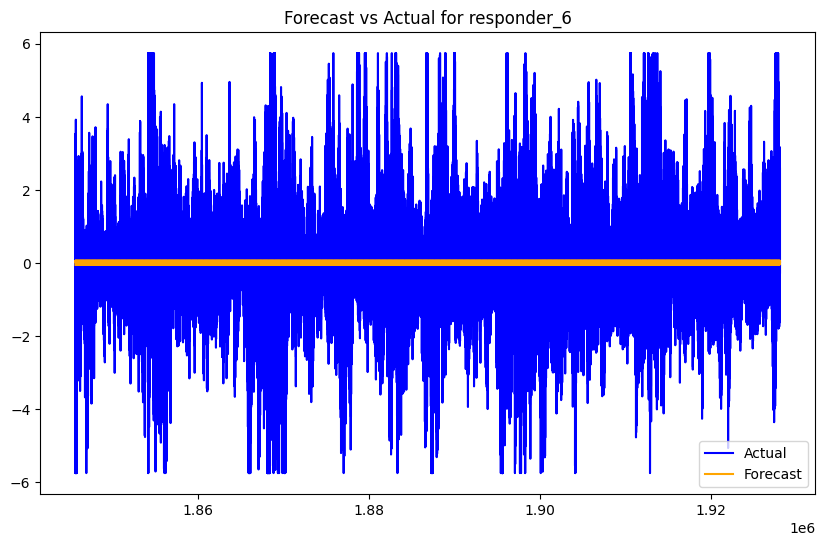

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# for col in ground_truth.columns:
#     mae = mean_absolute_error(ground_truth[col], forecast_df[col])
#     mse = mean_squared_error(ground_truth[col], forecast_df[col])
#     rmse = np.sqrt(mse)
#     r2 = r2_score(ground_truth[col], forecast_df[col])
#     print(f"{col} - MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R2: {r2}")


for col in val.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(ground_truth[col], label='Actual', color='blue')
    plt.plot(forecast_df[col], label='Forecast', color='orange')
    plt.title(f'Forecast vs Actual for {col}')
    plt.legend()
    plt.show()

## Conclusions

In retrospect, maybe this was not an appropriate model selection for this specific problem because although VAR models are suited for time-series data, this problem could potentially be requiring it to predict too far into the future. Another potential issue is that we just implemented it wrong for this application since we do not have very much experience with implementing time-series models. I think we will need to learn more about time-series modeling in the future.